#Import packages and libraries

In [ ]:
import cv2
import pandas as pd
import numpy as np
import os
from skimage.filters import roberts, sobel, scharr, prewitt
from scipy import ndimage as nd
import time
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import PrecisionRecallDisplay
import pickle
from sklearn.ensemble import RandomForestClassifier

#Paths' files

In [ ]:
train_path = "/content/drive/MyDrive/augmented_train1/"
test_path = "/content/drive/MyDrive/augmented_test1/"
mask_path ="/content/drive/MyDrive/augmented_masks1/"

#Features extraction function

In [ ]:
def feature_extractor(path,mask_path):
    Dataset = pd.DataFrame()
    i =1 # for monitoring the operation process
    for image in os.listdir(path):  # iterate through each file
        #print(i)
        df = pd.DataFrame()
        if image.split('.')[0][:3] == 'Def': # first three letters of each defect type
            mask1 = cv2.imread(mask_path + image)
            mask1 = cv2.cvtColor(mask1, cv2.COLOR_BGR2GRAY)
            ret,bi_mask = cv2.threshold(mask1,192,255,cv2.THRESH_BINARY)
            mask = cv2.resize(bi_mask, (150, 150))//255 #to make the classes confined between 1 and 0 only for each pixel
            df["label"] = mask.reshape(-1) # the label of each defected tile images is its binary mask
        else:
            df["label"] = np.zeros((150, 150)).reshape(-1) #if the image not for defected tile its label is (0)

        input_img = cv2.imread(path + image)  # Read images

        img = cv2.resize(input_img,(150, 150))
        blue_channel, green_channel, red_channel = cv2.split(img)

        # تحويل الصورة إلى مساحة لونية HSV
        hsv_image = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        h_channel, s_channel, v_channel = cv2.split(hsv_image)
        # تحويل الصورة إلى مساحة لونية LAB
        lab_image = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
        l_channel, a_channel, b_channel = cv2.split(lab_image)

        img = cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)
        pixel_values = img.reshape(-1)/255.0
        df['Pixel_Value'] = pd.DataFrame(pixel_values)

        blue_channel = blue_channel.reshape(-1)/255.0
        df['blue_channel'] = pd.DataFrame(blue_channel)

        green_channel = green_channel.reshape(-1)/255.0
        df['green_channel'] = pd.DataFrame(green_channel)

        red_channel = red_channel.reshape(-1)/255.0
        df['red_channel'] = pd.DataFrame(red_channel)

        h_channel = h_channel.reshape(-1)/255.0
        df['h_channel'] = pd.DataFrame(h_channel)

        s_channel = s_channel.reshape(-1)/255.0
        df['s_channel'] = pd.DataFrame(s_channel)

        v_channel = v_channel.reshape(-1)/255.0
        df['v_channel'] = pd.DataFrame(v_channel)

        l_channel = l_channel.reshape(-1)/255.0
        df['l_channel'] = pd.DataFrame(l_channel)

        a_channel = a_channel.reshape(-1)/255.0
        df['a_channel'] = pd.DataFrame(a_channel)

        b_channel = b_channel.reshape(-1)/255.0
        df['b_channel'] = pd.DataFrame(b_channel)

        print(i)
        i += 1  #Increment for gabor column label


        Dataset = pd.concat([Dataset,df])

    return Dataset

#Extracting training set

In [ ]:
Training_data= feature_extractor(train_path,mask_path)


In [ ]:
Training_data.to_csv(r'/content/drive/MyDrive/Colab Notebooks/Gabor_Leather_def_data2.csv', index=False)

In [ ]:
Training_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Gabor_Leather_def_data.csv')

In [ ]:
#Training_data = Training_data[Training_data.label != 0]
X_train= Training_data[['Pixel_Value',
 's_channel',
 'blue_channel',
 'h_channel'
]]
X_train.info()
#Scaling training set if needed
'''from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
X_train = min_max_scaler.fit_transform(X_train)'''

y_train = Training_data['label'].values

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11047500 entries, 0 to 22499
Data columns (total 4 columns):
 #   Column        Dtype  
---  ------        -----  
 0   Pixel_Value   float64
 1   s_channel     float64
 2   blue_channel  float64
 3   h_channel     float64
dtypes: float64(4)
memory usage: 421.4 MB


In [ ]:
X_train.head()

,s_channel,blue_channel
0,0.078431,0.325490
1,0.035294,0.329412
2,0.050980,0.298039
3,0.047059,0.325490
4,0.015686,0.454902


In [ ]:
np.unique(y_train)

array([0., 1.])

#Training the model

In [ ]:
RF_model = RandomForestClassifier()
#Calculating training time
t0 = time.time()
RF_model.fit(X_train,y_train)
Training_time = time.time()-t0
print("Training_time", Training_time)

Training_time 3219.540654182434


#Estimating each feature importance with sorting

In [ ]:
Feature_importance = {}
for score, name in zip(RF_model.feature_importances_, X_train.columns):
  Feature_importance[name] = round(score, 2)
sorted_Feature_importance = {k: v for k, v in sorted(Feature_importance.items(), key=lambda item: item[1],reverse=True)}
sorted_Feature_importance

{'s_channel': 0.64, 'blue_channel': 0.25, 'h_channel': 0.11}

In [ ]:
import xgboost as xgb

In [ ]:
params = {
    'max_depth': 3,
    'eta': 0.1,
    'objective': 'binary:logistic'
}

In [ ]:
XGB_model = xgb.XGBClassifier(**params)

In [ ]:
t0 = time.time()
XGB_model.fit(X_train, y_train)
Training_time = time.time()-t0
print("Training_time", Training_time)

Training_time 436.9192593097687


In [ ]:
Feature_importance = {}
for score, name in zip(XGB_model.feature_importances_, X_train.columns):
  Feature_importance[name] = round(score, 2)
sorted_Feature_importance = {k: v for k, v in sorted(Feature_importance.items(), key=lambda item: item[1],reverse=True)}
sorted_Feature_importance

{'s_channel': 0.67, 'blue_channel': 0.18, 'h_channel': 0.15}

In [ ]:
import lightgbm as lgb

In [ ]:
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

train_data = lgb.Dataset(X_train, label=y_train)
t0 = time.time()
LGB_model = lgb.train(params, train_data, num_boost_round=100)
Training_time = time.time()-t0
print("Training_time", Training_time)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.622657 seconds.
You can set `force_col_wise=true` to remove the overhead.
Training_time 179.51299667358398


In [ ]:
# Get feature importances
feature_importance = LGB_model.feature_importance()

# Get feature names
feature_names = LGB_model.feature_name()

# Create a feature importance dataframe
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

# Sort the features by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print the feature importance
print(feature_importance_df)

        Feature  Importance
3     h_channel        1018
2  blue_channel         937
1     s_channel         731
0   Pixel_Value         314


In [ ]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 10.5 MB/s eta 0:00:00


In [ ]:
from catboost import CatBoostClassifier

In [ ]:
CB_model = CatBoostClassifier()
t0 = time.time()
CB_model.fit(X_train, y_train)
Training_time = time.time()-t0
print("Training_time", Training_time)

In [ ]:
Feature_importance = {}
for score, name in zip(CB_model.feature_importances_, X_train.columns):
  Feature_importance[name] = round(score, 2)
sorted_Feature_importance = {k: v for k, v in sorted(Feature_importance.items(), key=lambda item: item[1],reverse=True)}
sorted_Feature_importance

{'blue_channel': 36.43,
 'h_channel': 33.66,
 's_channel': 25.52,
 'Pixel_Value': 4.39}

#Extracting testing data

In [ ]:
Testing_data = feature_extractor(test_path,mask_path)


In [ ]:
#Testing_data = Testing_data[Testing_data.label != 0]
X_test = Testing_data.drop(labels=['label'],axis = 1)

y_test = Testing_data['label'].values

In [ ]:
model_name = "RF_model"
pickle.dump(RF_model, open('/content/drive/MyDrive/Colab Notebooks/RF_Gabor1.pkl', 'wb'))

In [ ]:
model_name = "XGB_model"
pickle.dump(XGB_model, open('/content/drive/MyDrive/Colab Notebooks/XGB_Gabor1.pkl', 'wb'))

In [ ]:
model_name = "SVM_model"
pickle.dump(LGB_model, open('/content/drive/MyDrive/Colab Notebooks/LGB_Gabor1.pkl', 'wb'))

In [ ]:
model_name = "CB_model"
pickle.dump(CB_model, open('/content/drive/MyDrive/Colab Notebooks/CB_Gabor1.pkl', 'wb'))

#Estimating model metrics

Accuracy RF_model=  0.97184536271809
Precision RF_model=  0.9127941004331032
Recall RF_model=  0.39327892139969234
F1 Score RF_model=  0.5497130302478455 



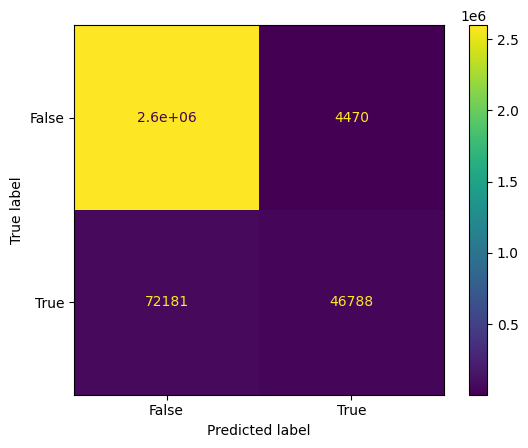

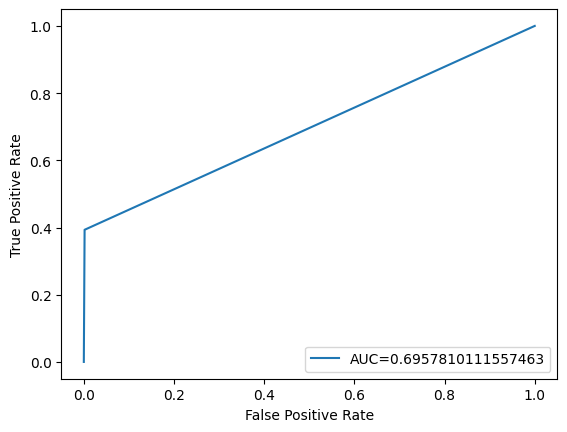

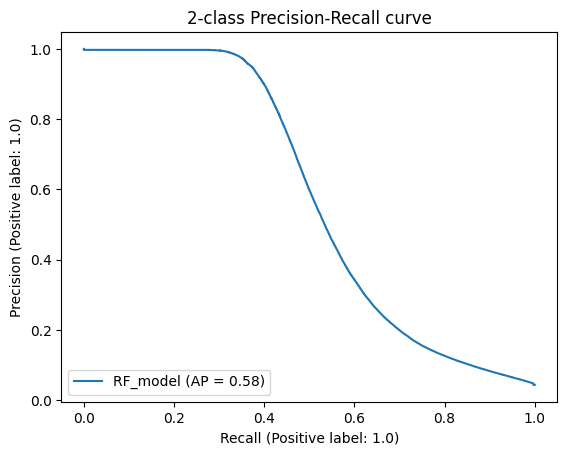

In [ ]:
test_prediction = RF_model.predict(X_test)
print ("Accuracy RF_model= ", metrics.accuracy_score(y_test, test_prediction))
print ("Precision RF_model= ", metrics.precision_score(y_test, test_prediction))
print ("Recall RF_model= ", metrics.recall_score(y_test, test_prediction))
print ("F1 Score RF_model= ", metrics.f1_score(y_test, test_prediction),"\n")
#Confusion matrix plotting
confusion_matrix = metrics.confusion_matrix(y_test, test_prediction)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()
#AUC curve plotting
fpr, tpr, _ = metrics.roc_curve(y_test,  test_prediction)
auc = metrics.roc_auc_score(y_test, test_prediction)
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()
#Precision - Recall curve plotting
display = PrecisionRecallDisplay.from_estimator(
  RF_model, X_test, y_test, name= "RF_model" )
_ = display.ax_.set_title("2-class Precision-Recall curve")

Accuracy XGB_model=  0.9703463728191001
Precision XGB_model=  0.907722164167964
Recall XGB_model=  0.35777387386630133
F1 Score XGB_model=  0.5132521403593393 



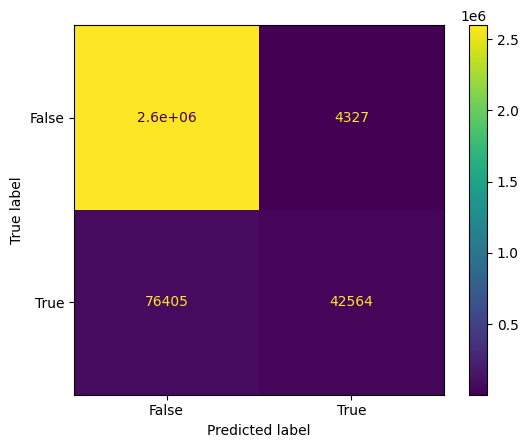

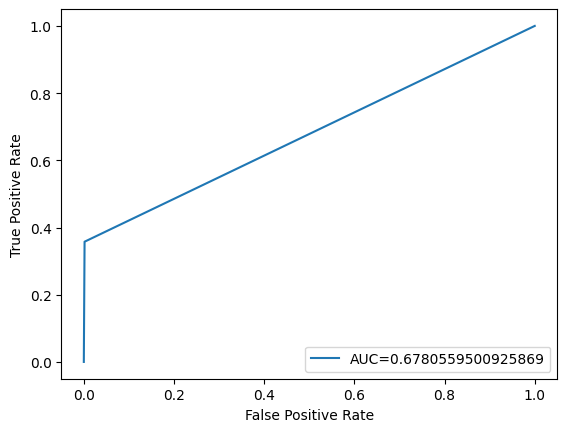

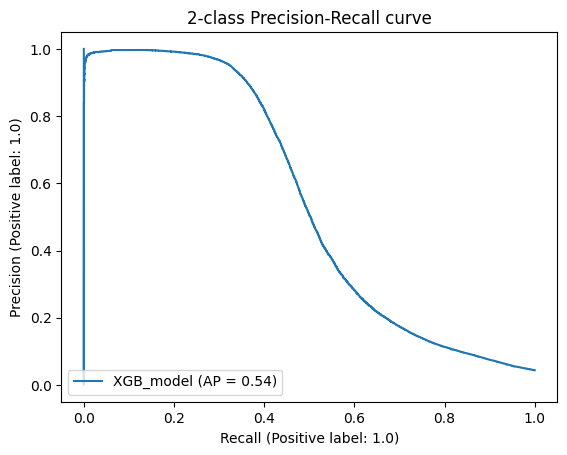

In [ ]:
test_prediction = XGB_model.predict(X_test)
print ("Accuracy XGB_model= ", metrics.accuracy_score(y_test, test_prediction))
print ("Precision XGB_model= ", metrics.precision_score(y_test, test_prediction))
print ("Recall XGB_model= ", metrics.recall_score(y_test, test_prediction))
print ("F1 Score XGB_model= ", metrics.f1_score(y_test, test_prediction),"\n")
#Confusion matrix plotting
confusion_matrix = metrics.confusion_matrix(y_test, test_prediction)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()
#AUC curve plotting
fpr, tpr, _ = metrics.roc_curve(y_test,  test_prediction)
auc = metrics.roc_auc_score(y_test, test_prediction)
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()
#Precision - Recall curve plotting
display = PrecisionRecallDisplay.from_estimator(
  XGB_model, X_test, y_test, name= "XGB_model" )
_ = display.ax_.set_title("2-class Precision-Recall curve")

Accuracy CB_model=  0.9710288337924702
Precision CB_model=  0.9055325174471528
Recall CB_model=  0.3762744916743017
F1 Score CB_model=  0.5316382033680911 



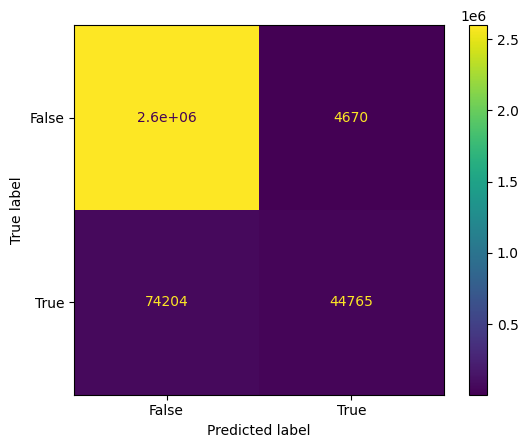

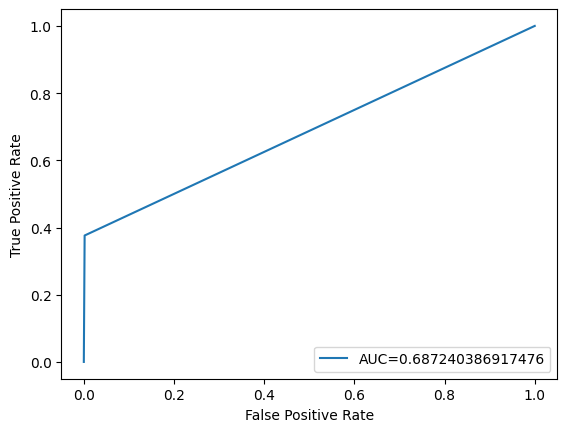

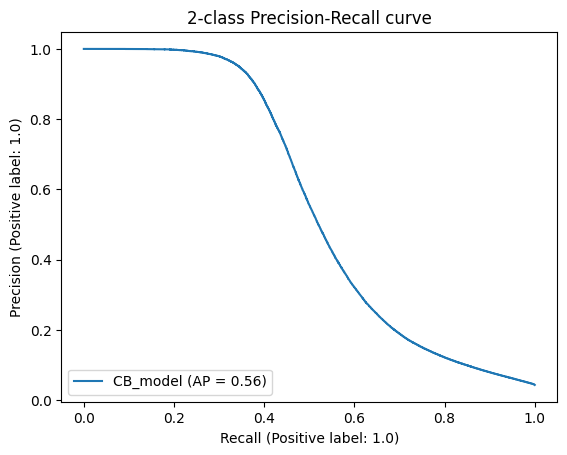

In [ ]:
test_prediction = CB_model.predict(X_test)
print ("Accuracy CB_model= ", metrics.accuracy_score(y_test, test_prediction))
print ("Precision CB_model= ", metrics.precision_score(y_test, test_prediction))
print ("Recall CB_model= ", metrics.recall_score(y_test, test_prediction))
print ("F1 Score CB_model= ", metrics.f1_score(y_test, test_prediction),"\n")
#Confusion matrix plotting
confusion_matrix = metrics.confusion_matrix(y_test, test_prediction)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()
#AUC curve plotting
fpr, tpr, _ = metrics.roc_curve(y_test,  test_prediction)
auc = metrics.roc_auc_score(y_test, test_prediction)
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()
#Precision - Recall curve plotting
display = PrecisionRecallDisplay.from_estimator(
  CB_model, X_test, y_test, name= "CB_model" )
_ = display.ax_.set_title("2-class Precision-Recall curve")

Accuracy LGB_model=  0.970732782369146
Precision LGB_model=  0.9029227771510614
Recall LGB_model=  0.37002916726205987
F1 Score LGB_model=  0.5249338198468914 



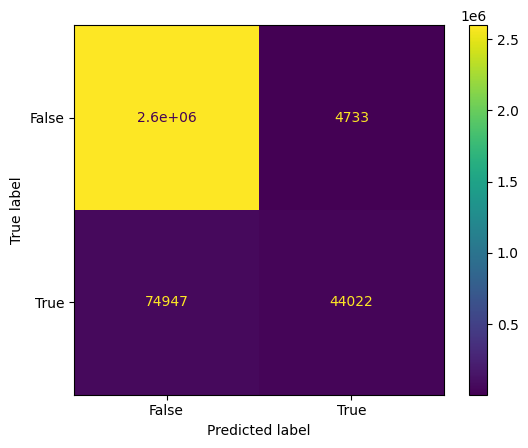

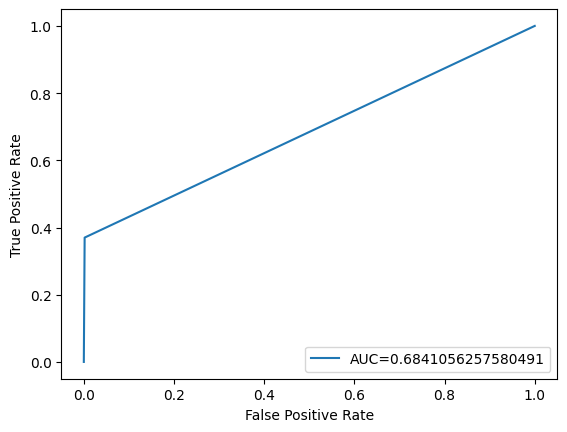

In [ ]:
test_prediction = LGB_model.predict(X_test)
y_pred_binary = (test_prediction > 0.5).astype(int)
y_test_binary = y_test.astype(int)
print ("Accuracy LGB_model= ", metrics.accuracy_score(y_test_binary, y_pred_binary))
print ("Precision LGB_model= ", metrics.precision_score(y_test_binary, y_pred_binary))
print ("Recall LGB_model= ", metrics.recall_score(y_test_binary, y_pred_binary))
print ("F1 Score LGB_model= ", metrics.f1_score(y_test_binary, y_pred_binary),"\n")
#Confusion matrix plotting
confusion_matrix = metrics.confusion_matrix(y_test_binary, y_pred_binary)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()
#AUC curve plotting
fpr, tpr, _ = metrics.roc_curve(y_test_binary,  y_pred_binary)
auc = metrics.roc_auc_score(y_test_binary, y_pred_binary)
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()
#Precision - Recall curve plotting
from sklearn.metrics import precision_recall_curve, average_precision_score
precision, recall, thresholds = precision_recall_curve(y_test_binary, y_pred_binary)
ap = average_precision_score(y_test_binary, y_pred_binary)
print("Average Precision:", ap)

In [ ]:
RF_features = {'cA': 0.19,
 'cD': 0.13,
 'magnitude_spectrum': 0.12,
 'real_part': 0.12,
 'imaginary_part': 0.12,
 'cH': 0.12,
 'cV': 0.12,
 'Pixel_Value': 0.08}

XGB_features ={'cA': 0.28,
 'cD': 0.17,
 'Pixel_Value': 0.14,
 'cH': 0.11,
 'cV': 0.1,
 'magnitude_spectrum': 0.06,
 'real_part': 0.06,
 'imaginary_part': 0.06}

LGB_features = {'cA'  : 0.30,
'cV'  : 0.13,
'cH' : 0.14,
'Pixel_Value' : 0.10,
'magnitude_spectrum' : 0.08,
'real_part' : 0.06,
'imaginary_part' : 0.07,
'cD' : 0.12
}
CB_features = {'cA': 0.28,
 'cH': 0.18,
 'cV': 0.17,
 'cD': 0.14,
 'Pixel_Value': 0.07,
 'magnitude_spectrum': 0.07,
 'imaginary_part': 0.05,
 'real_part': 0.04}


In [ ]:
features_importantly = pd.DataFrame()
features_importantly['XGB_features'] = XGB_features
features_importantly['LGB_features'] = LGB_features
features_importantly['RF_features'] = RF_features
features_importantly['CB_features'] = CB_features

In [ ]:
features_importantly

,XGB_features,LGB_features,RF_features,CB_features
cA,0.28,0.30,0.19,0.28
cD,0.17,0.12,0.13,0.14
Pixel_Value,0.14,0.10,0.08,0.07
cH,0.11,0.14,0.12,0.18
cV,0.10,0.13,0.12,0.17
magnitude_spectrum,0.06,0.08,0.12,0.07
real_part,0.06,0.06,0.12,0.04
imaginary_part,0.06,0.07,0.12,0.05


In [ ]:
features_importantly1 = features_importantly.copy()

In [ ]:
features_importantly1['RF_features'] = features_importantly1['RF_features'] *18.04
features_importantly1['XGB_features'] = features_importantly1['XGB_features']*14.52
features_importantly1['LGB_features'] = features_importantly1['LGB_features']*14.68
features_importantly1['CB_features'] = features_importantly1['CB_features'] * 16.54

In [ ]:
features_importantly1.head()

,XGB_features,LGB_features,RF_features,CB_features
cA,59.032512,64.650720,61.833904,76.600048
cD,35.841168,25.860288,42.307408,38.300024
Pixel_Value,29.516256,21.550240,26.035328,19.150012
cH,23.191344,30.170336,39.052992,49.242888
cV,21.083040,28.015312,39.052992,46.507172


In [ ]:
features_important = features_importantly1.sum(axis = 1)

In [ ]:
features_important.sort_values(ascending
                              = False)

cA                    16.5284
cD                     8.8908
cH                     8.7944
cV                     8.3370
Pixel_Value            6.1018
magnitude_spectrum     5.3682
imaginary_part         4.8906
real_part              4.5784
dtype: float64

#Test pridiction's output

In [ ]:
def one_sample_feature_extractor (image):
  input_img = cv2.imread(image)  # Read images
  img = cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)
  img = cv2.resize(img, (210, 210))

  df= pd.DataFrame()
  '''pixel_values = img.reshape(-1)/255.0
  df['Pixel_Value'] = pd.DataFrame(pixel_values)'''   #Pixel value itself as a feature
  #Defining the desired filter (feature).
  edge_roberts = roberts(img)
  edge_roberts1 = edge_roberts.reshape(-1)
  df['Roberts'] = pd.DataFrame(edge_roberts1)

  '''# SOBEL
  edge_sobel = sobel(img)
  edge_sobel1 = edge_sobel.reshape(-1)
  df['Sobel'] = pd.DataFrame(edge_sobel1)

  # VARIANCE with size=3
  variance_img = nd.generic_filter(img, np.var, size=3)
  edge_variance = variance_img.reshape(-1)/255.0
  df['variance'] = pd.DataFrame(edge_variance)'''

  # GAUSSIAN with sigma=3
  gaussian_img = nd.gaussian_filter(img, sigma=3)
  gaussian_img1 = gaussian_img.reshape(-1)/255.0
  df['Gaussian3'] = pd.DataFrame(gaussian_img1)

  # SCHARR
  edge_scharr = scharr(img)
  edge_scharr1 = edge_scharr.reshape(-1)
  df['Scharr'] = pd.DataFrame(edge_scharr1)

  # PREWITT
  edge_prewitt = prewitt(img)
  edge_prewitt1 = edge_prewitt.reshape(-1)
  df['Prewitt'] = pd.DataFrame(edge_prewitt1)

  '''# MEDIAN with sigma=3
  median_img = nd.median_filter(img, size=3)
  median_img1 = median_img.reshape(-1)/255.0
  df['Median3'] = pd.DataFrame(median_img1)

  # CANNY EDGE
  edges = cv2.Canny(img, 100, 200)  # Image, min and max values
  edges1 = edges.reshape(-1)/255.0
  df['Canny_Edge'] = pd.DataFrame(edges1)'''
  return df

In [ ]:
test = one_sample_feature_extractor(test_path + 'crack6.png')
predicted = RF_model.predict(test)
predicted = predicted.reshape((210,210))*255.0
from google.colab.patches import cv2_imshow
cv2_imshow(predicted)
print('\n')
from google.colab.patches import cv2_imshow
mask = cv2.imread(mask_path + 'crack6.png')
mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
ret,bi_mask = cv2.threshold(mask,192,255,cv2.THRESH_BINARY)
mask = cv2.resize(bi_mask, (210, 210))
cv2_imshow(mask)


In [ ]:
test = one_sample_feature_extractor(test_path + 'oil2.png')
predicted = RF_model.predict(test)
predicted = predicted.reshape((210,210))*255.0
from google.colab.patches import cv2_imshow
cv2_imshow(predicted)
print('\n')
from google.colab.patches import cv2_imshow
mask = cv2.imread(mask_path + 'oil2.png')
mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
ret,bi_mask = cv2.threshold(mask,192,255,cv2.THRESH_BINARY)
mask = cv2.resize(bi_mask, (210, 210))
cv2_imshow(mask)

In [ ]:
test = one_sample_feature_extractor(test_path + 'glue_strip17.png')
predicted = RF_model.predict(test)
predicted = predicted.reshape((210,210))*255.0
from google.colab.patches import cv2_imshow
cv2_imshow(predicted)
print('\n')
from google.colab.patches import cv2_imshow
mask = cv2.imread(mask_path + 'glue_strip17.png')
mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
ret,bi_mask = cv2.threshold(mask,192,255,cv2.THRESH_BINARY)
mask = cv2.resize(bi_mask, (210, 210))
cv2_imshow(mask)

In [ ]:
test = one_sample_feature_extractor(test_path + 'gray_stroke6.png')
predicted = RF_model.predict(test)
predicted = predicted.reshape((210,210))*255.0
from google.colab.patches import cv2_imshow
cv2_imshow(predicted)
print('\n')
from google.colab.patches import cv2_imshow
mask = cv2.imread(mask_path + 'gray_stroke6.png')
mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
ret,bi_mask = cv2.threshold(mask,192,255,cv2.THRESH_BINARY)
mask = cv2.resize(bi_mask, (210, 210))
cv2_imshow(mask)

In [ ]:
test = one_sample_feature_extractor(test_path + 'rough11.png')
predicted = RF_model.predict(test)
predicted = predicted.reshape((210,210))*255.0
from google.colab.patches import cv2_imshow
cv2_imshow(predicted)
print('\n')
from google.colab.patches import cv2_imshow
mask = cv2.imread(mask_path + 'rough11.png')
mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
ret,bi_mask = cv2.threshold(mask,192,255,cv2.THRESH_BINARY)
mask = cv2.resize(bi_mask, (210, 210))
cv2_imshow(mask)

#Model evaluation on each type of defects

##Crack test

In [ ]:
Crack_test_data = feature_extractor('/content/drive/MyDrive/Colab Notebooks/crac_test/',mask_path)
Crack_test = Crack_test_data.drop(labels =['label'], axis=1)
y_label = Crack_test_data['label'].values

predict1 = RF_model.predict(Crack_test)
print ("Accuracy RF_model = ", metrics.accuracy_score(y_label, predict1))
print ("Precision RF_model = ", metrics.precision_score(y_label, predict1))
print ("Recall RF_model = ", metrics.recall_score(y_label, predict1))
print ("F1 Score RF_model = ", metrics.f1_score(y_label, predict1),"\n")
#Confusion matrix plotting
confusion_matrix = metrics.confusion_matrix(y_label, predict1)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()
#AUC curve plotting
fpr, tpr, _ = metrics.roc_curve(y_label,  predict1)
auc = metrics.roc_auc_score(y_label, predict1)
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()
#Precision - Recall curve plotting
display = PrecisionRecallDisplay.from_estimator(
  RF_model, Crack_test, y_label, name="RF_model")
_ = display.ax_.set_title("2-class Precision-Recall curve")

##Glue_strip test

In [ ]:
Glue_strip_test_data = feature_extractor('/content/drive/MyDrive/Colab Notebooks/glue_strip_test/',mask_path)
Glue_strip_test = Glue_strip_test_data.drop(labels =['label'], axis=1)
y_label = Glue_strip_test_data['label'].values

predict1 = RF_model.predict(Glue_strip_test)
print ("Accuracy RF_model = ", metrics.accuracy_score(y_label, predict1))
print ("Precision RF_model = ", metrics.precision_score(y_label, predict1))
print ("Recall RF_model = ", metrics.recall_score(y_label, predict1))
print ("F1 Score RF_model = ", metrics.f1_score(y_label, predict1),"\n")
#Confusion matrix plotting
confusion_matrix = metrics.confusion_matrix(y_label, predict1)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()
#AUC curve plotting
fpr, tpr, _ = metrics.roc_curve(y_label,  predict1)
auc = metrics.roc_auc_score(y_label, predict1)
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()
#Precision - Recall curve plotting
display = PrecisionRecallDisplay.from_estimator(
  RF_model, Glue_strip_test, y_label, name="RF_model")
_ = display.ax_.set_title("2-class Precision-Recall curve")

##Gray_stroke test

In [ ]:
Gray_stroke_test_data = feature_extractor('/content/drive/MyDrive/Colab Notebooks/gray_stroke_test/',mask_path)
Gray_stroke_test = Gray_stroke_test_data.drop(labels =['label'], axis=1)
y_label = Gray_stroke_test_data['label'].values

predict1 = RF_model.predict(Gray_stroke_test)
print ("Accuracy RF_model = ", metrics.accuracy_score(y_label, predict1))
print ("Precision RF_model = ", metrics.precision_score(y_label, predict1))
print ("Recall RF_model = ", metrics.recall_score(y_label, predict1))
print ("F1 Score RF_model = ", metrics.f1_score(y_label, predict1),"\n")
#Confusion matrix plotting
confusion_matrix = metrics.confusion_matrix(y_label, predict1)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()
#AUC curve plotting
fpr, tpr, _ = metrics.roc_curve(y_label,  predict1)
auc = metrics.roc_auc_score(y_label, predict1)
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()
#Precision - Recall curve plotting
display = PrecisionRecallDisplay.from_estimator(
  RF_model, Gray_stroke_test, y_label, name="RF_model")
_ = display.ax_.set_title("2-class Precision-Recall curve")

##Oil test

In [ ]:
Oil_test_data = feature_extractor('/content/drive/MyDrive/Colab Notebooks/oil_test/',mask_path)
Oil_test = Oil_test_data.drop(labels =['label'], axis=1)
y_label = Oil_test_data['label'].values

predict1 = RF_model.predict(Oil_test)
print ("Accuracy RF_model = ", metrics.accuracy_score(y_label, predict1))
print ("Precision RF_model = ", metrics.precision_score(y_label, predict1))
print ("Recall RF_model = ", metrics.recall_score(y_label, predict1))
print ("F1 Score RF_model = ", metrics.f1_score(y_label, predict1),"\n")
#Confusion matrix plotting
confusion_matrix = metrics.confusion_matrix(y_label, predict1)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()
#AUC curve plotting
fpr, tpr, _ = metrics.roc_curve(y_label,  predict1)
auc = metrics.roc_auc_score(y_label, predict1)
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()
#Precision - Recall curve plotting
display = PrecisionRecallDisplay.from_estimator(
  RF_model, Oil_test, y_label, name="RF_model")
_ = display.ax_.set_title("2-class Precision-Recall curve")

##Rough test

In [ ]:
Rough_test_data = feature_extractor('/content/drive/MyDrive/Colab Notebooks/rough_test/',mask_path)
Rough_test = Rough_test_data.drop(labels =['label'], axis=1)
y_label = Rough_test_data['label'].values

predict1 = RF_model.predict(Rough_test)
print ("Accuracy RF_model = ", metrics.accuracy_score(y_label, predict1))
print ("Precision RF_model = ", metrics.precision_score(y_label, predict1))
print ("Recall RF_model = ", metrics.recall_score(y_label, predict1))
print ("F1 Score RF_model = ", metrics.f1_score(y_label, predict1),"\n")
#Confusion matrix plotting
confusion_matrix = metrics.confusion_matrix(y_label, predict1)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()
#AUC curve plotting
fpr, tpr, _ = metrics.roc_curve(y_label,  predict1)
auc = metrics.roc_auc_score(y_label, predict1)
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()
#Precision - Recall curve plotting
display = PrecisionRecallDisplay.from_estimator(
  RF_model, Rough_test, y_label, name="RF_model")
_ = display.ax_.set_title("2-class Precision-Recall curve")

In [ ]:
from yellowbrick.classifier import ROCAUC
print("Classes in the image are: ", np.unique(y_train))

#ROC curve for RF
roc_auc=ROCAUC(RF_model, classes=np.unique(y_train))  #Create object
roc_auc.fit(X_train, y_train)
roc_auc.score(X_test, y_test)
roc_auc.show()